In [1]:
#http://www.mia.uni-saarland.de/weickert/book.html
#http://www.mia.uni-saarland.de/weickert/Papers/book.pdf
#https://github.com/loli/medpy/blob/master/medpy/filter/smoothing.py


In [4]:
import numpy
from scipy.ndimage.filters import gaussian_filter

# path changes

import numpy
from scipy.ndimage import _ni_support



# code
def xminus1d(img, fun, dim, *args, **kwargs):
    r"""
    Applies the function fun along all X-1D dimensional volumes of the images img
    dimension dim.
    
    E.g. you want to apply a gauss filter to each slice of a 3D MRI brain image,
    simply supply the function as fun, the image as img and the dimension along which
    to iterate as dim.
    
    Parameters
    ----------
    img : ndarray
        The image to apply the function ``fun`` to.
    fun : function
        A image modification function.
    dim : integer
        The dimension along which to apply the function.
    
    Returns
    -------
    output : ndarray
        The result of the operation over the image ``img``.
    
    Notes
    -----
    With ``*args`` and ``**kwargs``, arguments can be passed to the function ``fun``.
    """
    slicer = [slice(None)] * img.ndim
    output = []
    for slid in range(img.shape[dim]):
        slicer[dim] = slice(slid, slid + 1)
        output.append(fun(numpy.squeeze(img[slicer]), *args, **kwargs))
    return numpy.rollaxis(numpy.asarray(output), 0, dim + 1)


# code
def gauss_xminus1d(img, sigma, dim=2):
    r"""
    Applies a X-1D gauss to a copy of a XD image, slicing it along dim.
    Essentially uses `scipy.ndimage.filters.gaussian_filter`, but
    applies it to a dimension less than the image has.
    Parameters
    ----------
    img : array_like
        The image to smooth.
    sigma : integer
        The sigma i.e. gaussian kernel size in pixel
    dim : integer
        The dimension along which to apply the filter.
    Returns
    -------
    gauss_xminus1d : ndarray
        The input image ``img`` smoothed by a gaussian kernel along dimension ``dim``.
    """
    img = numpy.array(img, copy=False)
    return xminus1d(img, gaussian_filter, dim, sigma=sigma)

def anisotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    r"""
    Edge-preserving, XD Anisotropic diffusion.
    Parameters
    ----------
    img : array_like
        Input image (will be cast to numpy.float).
    niter : integer
        Number of iterations.
    kappa : integer
        Conduction coefficient, e.g. 20-100. ``kappa`` controls conduction
        as a function of the gradient. If ``kappa`` is low small intensity
        gradients are able to block conduction and hence diffusion across
        steep edges. A large value reduces the influence of intensity gradients
        on conduction.
    gamma : float
        Controls the speed of diffusion. Pick a value :math:`<= .25` for stability.
    voxelspacing : tuple of floats or array_like
        The distance between adjacent pixels in all img.ndim directions
    option : {1, 2, 3}
        Whether to use the Perona Malik diffusion equation No. 1 or No. 2,
        or Tukey's biweight function.
        Equation 1 favours high contrast edges over low contrast ones, while
        equation 2 favours wide regions over smaller ones. See [1]_ for details.
        Equation 3 preserves sharper boundaries than previous formulations and
        improves the automatic stopping of the diffusion. See [2]_ for details.
    Returns
    -------
    anisotropic_diffusion : ndarray
        Diffused image.
    Notes
    -----
    Original MATLAB code by Peter Kovesi,
    School of Computer Science & Software Engineering,
    The University of Western Australia,
    pk @ csse uwa edu au,
    <http://www.csse.uwa.edu.au>
    Translated to Python and optimised by Alistair Muldal,
    Department of Pharmacology,
    University of Oxford,
    <alistair.muldal@pharm.ox.ac.uk>
    Adapted to arbitrary dimensionality and added to the MedPy library Oskar Maier,
    Institute for Medical Informatics,
    Universitaet Luebeck,
    <oskar.maier@googlemail.com>
    June 2000  original version. -
    March 2002 corrected diffusion eqn No 2. -
    July 2012 translated to Python -
    August 2013 incorporated into MedPy, arbitrary dimensionality -
    References
    ----------
    .. [1] P. Perona and J. Malik.
       Scale-space and edge detection using ansotropic diffusion.
       IEEE Transactions on Pattern Analysis and Machine Intelligence,
       12(7):629-639, July 1990.
    .. [2] M.J. Black, G. Sapiro, D. Marimont, D. Heeger
       Robust anisotropic diffusion.
       IEEE Transactions on Image Processing,
       7(3):421-432, March 1998.
    """
    # define conduction gradients functions
    if option == 1:
        def condgradient(delta, spacing):
            return numpy.exp(-(delta/kappa)**2.)/float(spacing)
    elif option == 2:
        def condgradient(delta, spacing):
            return 1./(1.+(delta/kappa)**2.)/float(spacing)
    elif option == 3:
        kappa_s = kappa * (2**0.5)

        def condgradient(delta, spacing):
            top = 0.5*((1.-(delta/kappa_s)**2.)**2.)/float(spacing)
            return numpy.where(numpy.abs(delta) <= kappa_s, top, 0)

    # initialize output array
    out = numpy.array(img, dtype=numpy.float32, copy=True)

    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.] * img.ndim)

    # initialize some internal variables
    deltas = [numpy.zeros_like(out) for _ in range(out.ndim)]

    for _ in range(niter):

        # calculate the diffs
        for i in range(out.ndim):
            slicer = [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            deltas[i][slicer] = numpy.diff(out, axis=i)

        # update matrices
        matrices = [condgradient(delta, spacing) * delta for delta, spacing in zip(deltas, voxelspacing)]

        # subtract a copy that has been shifted ('Up/North/West' in 3D case) by one
        # pixel. Don't as questions. just do it. trust me.
        for i in range(out.ndim):
            slicer = [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            matrices[i][slicer] = numpy.diff(matrices[i], axis=i)

        # update the image
        out += gamma * (numpy.sum(matrices, axis=0))

    return out

In [5]:
import lightroot
%matplotlib inline
#pth  ="C:/Users/mrsir/Box Sync/uncut/Images/083117/149/"
pth  ="C:/Users/mrsir/Box Sync/uncut/Images/310717/"
lightroot.SETTINGS["stack_files"] = pth+"Run0140_tp{:0>3}.tif"
lightroot.SETTINGS["maxint_files"] = pth+"Run0140_tp{}_MIP.tif"

12/02/2018 18:05:47 INFO(None):loaded lightroot


12/02/2018 18:10:59 INFO(4):Stack loaded from C:/Users/mrsir/Box Sync/uncut/Images/310717/Run0140_tp004.tif


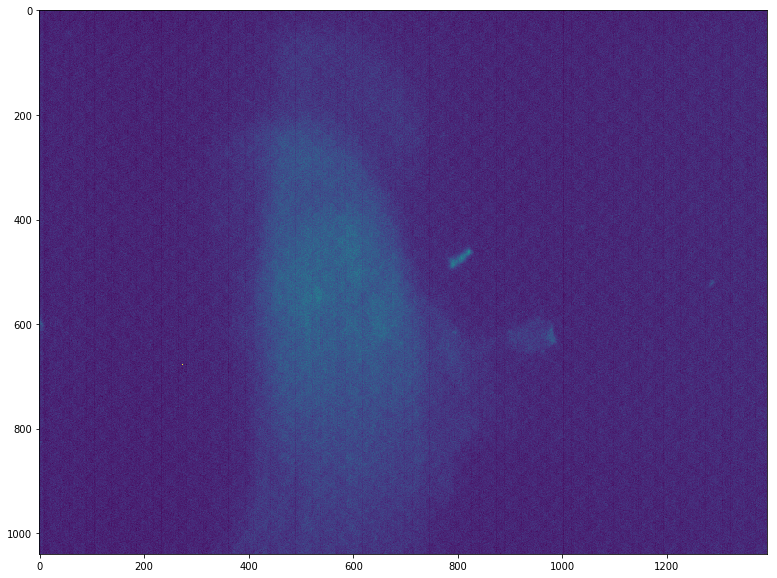

In [16]:
sample_time_frame =4
stack = lightroot.io.get_stack(sample_time_frame)
lightroot.io.plotimg(stack)

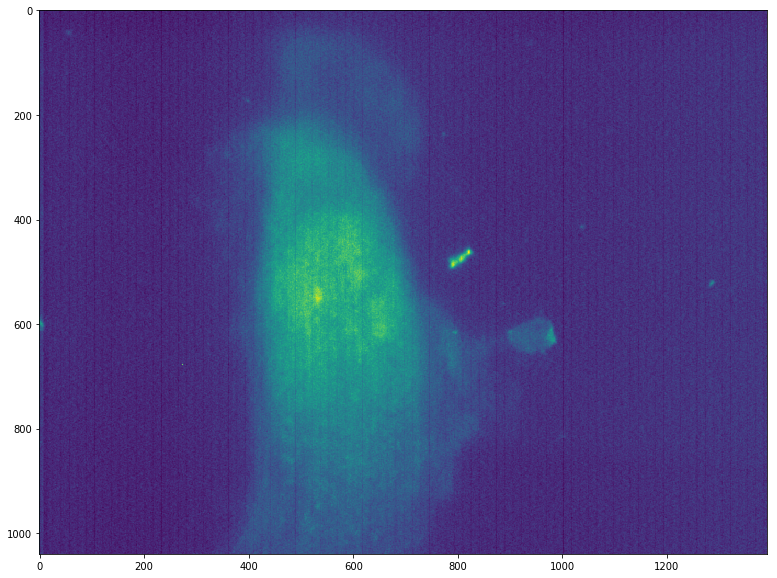

In [17]:
astack  = anisotropic_diffusion(stack,niter=3)
lightroot.io.plotimg(astack)

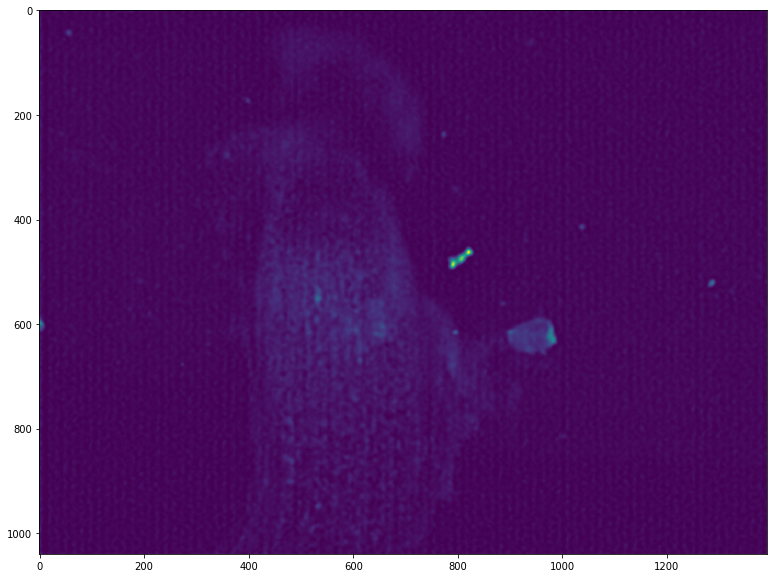

In [18]:
sharpend = lightroot.blobs.sharpen(stack)
lightroot.io.plotimg(sharpend)

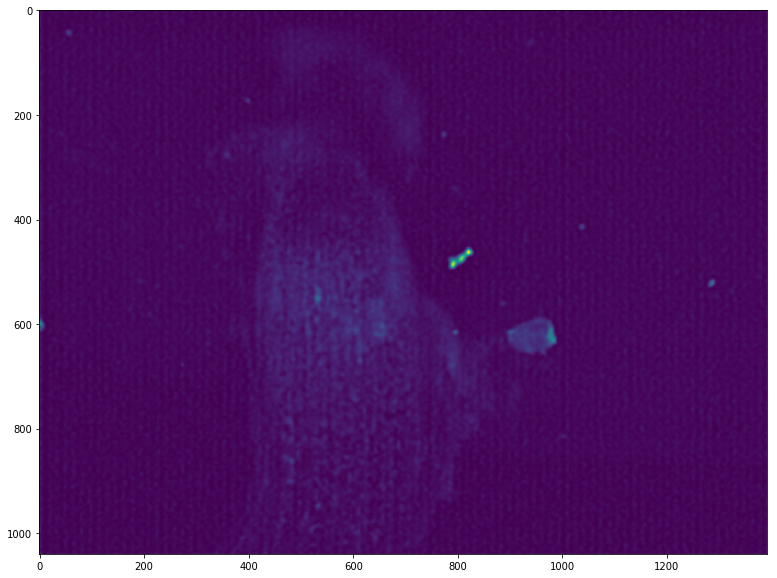

In [19]:
asharpend = lightroot.blobs.sharpen(astack)
lightroot.io.plotimg(asharpend)